# Deep Reinformcement Learning Project Submission
## Collaboration and Competition

A Dualing DDPG Reinforcement Learning implementation that trains two agents to play a game of tennis against each other.  

Two DDPG agents independently play against each other.  After each time step, each is trained using the data specific to the agent, with a batch size of 128.  After each epoch of 1000 episodes, the agents compete against each other to see which achieves a better score.  The agent with the better score is assumed to be the better agent.  The losing agent is then overwritten with the better agent's weights and the process is repeated until the agents are capable of meeting the project's requirements.

The environment is solved when the winning agent's score over 100 episodes is above 0.5.


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


### 2. Perform necessary imports and load the Unity Tennis environment. 

Examine the State and Action Spaces.  Instantiate the environment and set some variables with values necessary to interact with the environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('brain_name:', brain_name)

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents (num_agents):', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action (action_size):', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length (state_size): {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


brain_name: TennisBrain
Number of agents (num_agents): 2
Size of each action (action_size): 2
There are 2 agents. Each observes a state with length (state_size): 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 3. Define Models

 - ActorModel:  Take in a state and output an of action.  The final output's activation function is tanh, ensuring the output is between -1.0 and 1.0
 - CriticModel:  Take in a state AND actions - outputs a state value function (i.e. the expected discounted rewards for the given state and action)
 
Notes:  I Utilized BatchNormalization to improve the speed, performance, and stability of the networks

In [6]:
# define netowrks
import torch
import torch.nn.functional as F
import torch.optim as optim
import copy
import random

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class ActorModel(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorModel, self).__init__()
        self.state_size   = state_size
        self.action_size = action_size

        self.fc1 = torch.nn.Linear(state_size, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.out = torch.nn.Linear(256, action_size)
        self.reset_parameters()
        
    def forward(self, states):
        batch_size = states.size(0)
        x = self.fc1(states)
        x = F.relu(self.bn1(x))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.tanh(self.out(x))
        return x
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

class CriticModel(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticModel, self).__init__()
        self.state_size   = state_size
        self.action_size = action_size

        self.fc1 = torch.nn.Linear(state_size, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256+action_size, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.out = torch.nn.Linear(128, 1)
        self.reset_parameters()
        
    def forward(self, states, actions):
        batch_size = states.size(0)
        xs = F.leaky_relu(self.bn1(self.fc1(states)))
        x = torch.cat((xs, actions), dim=1) #add in actions to the network
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.out.weight.data.uniform_(-3e-3, 3e-3)




### 4. Define methods used for training

 - **reset_game**:  After an episode is complete, can be called to reset the environment to begin a new epiosode.
 - **StepInfo class**: Holds information related to a step performed on the environment.  Instances of this class are added to the replay buffer for training.
 - **env_step**:  Execute a timestep on the enviroment.  Given an instance of the environment and an actor model for each player, executes a time step and adds to the replay buffer.  Other implementations of DDPG use noise to allow the agents to explore new possibilities.  This one uses an episilon factor for exploration, which is the probability that a random action will be performed.
 - **soft_update_target**:  Transfers weights from one network to another.  The tau factor devines the degree to which the weights  are transferred.  (1.0 is a 100% copy, 0.0 is 0%).  This is key to the DDPG algorithim.
 - **getBatch**: Returns a batch of training data from the replay buffer.

In [7]:
def reset_game(in_env, brain_name):
    # **important note** When training the environment, set `train_mode=True`
    env_info = in_env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    return states

class StepInfo:
    def __init__(self, step_number, states, actions, rewards, next_states, dones):
        self.step_number = step_number
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.next_states = next_states
        self.dones = dones
        
    def __str__(self):
        return "step_number: {},  states: {},  actions: {},  rewards: {},  next_states: {}".format(self.step_number, self.states, self.actions, self.rewards, self.next_states)

def env_step(in_env, brain_name, states, replay_buffer, actor_model_0, actor_model_1, epsilon, logging=False):
    #Play a game. Add to the replay_buffer
    if (len(replay_buffer) > 0):
        step_number = replay_buffer[-1].step_number + 1
    else:
        step_number = 0

    state_tensor = torch.from_numpy(states).float().cuda()

    rand_num = random.uniform(0, 1)
    if rand_num > epsilon:
        actor_model_0.eval()
        actor_model_1.eval()
        actions_tensor_0 = actor_model_0(state_tensor[0].unsqueeze(0))
        actions_tensor_1 = actor_model_1(state_tensor[1].unsqueeze(0))
        actor_model_0.train()
        actor_model_1.train()
        actions_np = np.zeros((num_agents, action_size))
        actions_np[0] = actions_tensor_0.detach().cpu().numpy()
        actions_np[1] = actions_tensor_1.detach().cpu().numpy()
        if logging:
            print("actions from models: {}".format(actions_np))
    else:
        actions_np =  (2.0 * np.random.rand(num_agents, action_size)) - 1.0
        if logging:
            print("random actions: {}".format(actions_np))

    env_info = in_env.step(actions_np)[brain_name]      # send all actions to the environment
    next_states = env_info.vector_observations          # get next state (for each agent)
    rewards = env_info.rewards                          # get reward (for each agent)
    dones = env_info.local_done                         # see if episode finished

    this_step_info = StepInfo(step_number, states, actions_np, rewards, next_states, dones)
    replay_buffer.append(this_step_info)

    return next_states

def soft_update_target(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

def getBatch(replay_buffer, batch_size):
    return_states = np.zeros((batch_size, num_agents, state_size))
    return_actions = np.zeros((batch_size, num_agents, action_size))
    return_rewards = np.zeros((batch_size, 2))
    return_next_states = np.zeros((batch_size, num_agents, state_size))
    
#     print("replay_buffer[0].states.shape: {}".format(replay_buffer[0].states.shape))
#     print("replay_buffer[0].rewards[0]: {}".format(replay_buffer[0].rewards[0]))
#     print("replay_buffer[0].actions.shape: {}".format(replay_buffer[0].actions.shape))
#     print("replay_buffer[0].next_states.shape: {}".format(replay_buffer[0].next_states.shape))

    for i in range(batch_size):
        rand_frame_index = random.randint(0,len(replay_buffer)-2)
        return_states[i] = replay_buffer[rand_frame_index].states[0]
        return_actions[i] = replay_buffer[rand_frame_index].actions[0]
        return_rewards[i] = replay_buffer[rand_frame_index].rewards[0]
        return_next_states[i] = replay_buffer[rand_frame_index].next_states[0]
        #### TODO - make sure "next" actions don't roll over onto the next  playthrough.
        
    return return_states, return_actions, return_rewards, return_next_states

### 4. Instantiate models and Optimizers

Create the replay buffer, models, and optimizers used for playback and training.  Note the use of two separate DDPG players.

Notes:
 - The learning rates of 0.0005 were set through trial and error.
 - The replay buffer seems large, but works.
 - tuples are used to store player 1 and 2 networks so the train_player method (below) can be used for both players.

In [13]:
from collections import deque

# instantiate objects that will can be re-used
buffer_length = 100000
replay_buffer = deque(maxlen=buffer_length)

actor_model_local_0   = ActorModel(state_size, action_size).cuda()
actor_model_target_0  = ActorModel(state_size, action_size).cuda()
critic_model_local_0  = CriticModel(state_size, action_size).cuda()
critic_model_target_0 = CriticModel(state_size, action_size).cuda()

actor_model_local_1   = ActorModel(state_size, action_size).cuda()
actor_model_target_1  = ActorModel(state_size, action_size).cuda()
critic_model_local_1  = CriticModel(state_size, action_size).cuda()
critic_model_target_1 = CriticModel(state_size, action_size).cuda()

actor_model_locals   = (actor_model_local_0, actor_model_local_1)
actor_model_targets  = (actor_model_target_0, actor_model_target_1)
critic_model_locals  = (critic_model_local_0, critic_model_local_1)
critic_model_targets = (critic_model_target_0, critic_model_target_1)

if False:  # set to false if running for the first time or fresh models are desired.
    print("Loading models from disk")
    actor_model_locals[0].load_state_dict(torch.load("actor_model_local_0.pt"))
    actor_model_targets[0].load_state_dict(torch.load("actor_model_target_0.pt"))
    critic_model_locals[0].load_state_dict(torch.load("critic_model_local_0.pt"))
    critic_model_targets[0].load_state_dict(torch.load("critic_model_target_0.pt"))
    
    actor_model_locals[1].load_state_dict(torch.load("actor_model_local_1.pt"))
    actor_model_targets[1].load_state_dict(torch.load("actor_model_target_1.pt"))
    critic_model_locals[1].load_state_dict(torch.load("critic_model_local_1.pt"))
    critic_model_targets[1].load_state_dict(torch.load("critic_model_target_1.pt"))
else:
    print("Using fresh, untrained models.")

lr_actor = .0005 #learning rate of .001 is too high - losses going in wrong direction.
lr_critic = .0005
weight_decay = 0.0
actor_optimizer_0 = optim.Adam(actor_model_locals[0].parameters(), lr=lr_actor)
actor_optimizer_1 = optim.Adam(actor_model_locals[1].parameters(), lr=lr_actor)
critic_optimizer_0 = optim.Adam(critic_model_locals[0].parameters(), lr=lr_critic, weight_decay=weight_decay)
critic_optimizer_1 = optim.Adam(critic_model_locals[1].parameters(), lr=lr_critic, weight_decay=weight_decay)

actor_optimizers = (actor_optimizer_0, actor_optimizer_1)
critic_optimizers = (critic_optimizer_0, critic_optimizer_1)

actor_losses  = ([], [])
critic_losses = ([], [])
total_rewards = ([], [])

Using fresh, untrained models.


### 5. Perform training on a batch

Gets a batch of training data and trains using the DDPG algorithim on one of the players(0 or 1). Since BatchNormalization is being used, make sure that the networks are in eval() mode when training is not being performed on them.

In [14]:
def train_player(player_idx, batch_size, gamma, tau):
    #do some learning
    states, actions, rewards, next_states = getBatch(replay_buffer, batch_size)

    # convert to tensors for input into the models.
    rewards_tensor = torch.from_numpy(rewards[:,player_idx]).unsqueeze(1).float().cuda()
    # print("rewards_tensor.shape: {}".format(rewards_tensor.shape))
    next_states_tensor = torch.from_numpy(next_states[:,player_idx,:]).float().cuda()
    #     print("next_states_tensor.shape: {}".format(next_states_tensor.shape))
    states_tensor = torch.from_numpy(states[:,player_idx,:]).float().cuda()
    # print("states_tensor.shape: {}".format(states_tensor.shape))
    actions_tensor = torch.from_numpy(actions[:,player_idx,:]).float().cuda()
    # print("actions_tensor.shape: {}".format(actions_tensor.shape))

    actor_model_targets[player_idx].eval()
    actor_model_locals[player_idx].eval()
    critic_model_targets[player_idx].eval()
    critic_model_locals[player_idx].eval()
    
    # ---------------------------- update critic ---------------------------- #
    # Get predicted next-state actions and Q values from target models
    
    # Compute Q targets for current states (current reward plus discounted reward of the actor's next step
    # from the target networks)
    actions_next = actor_model_targets[player_idx](next_states_tensor)
    Q_targets_next = critic_model_targets[player_idx](next_states_tensor, actions_next)
    Q_targets = rewards_tensor + (gamma * Q_targets_next)

    # get expected Q values given the current state and action from the local critic network.
    Q_expected = critic_model_locals[player_idx](states_tensor, actions_tensor)
    
    # Compute critic loss
    critic_loss = F.mse_loss(Q_expected, Q_targets)

    # Minimize the critic loss
    critic_model_locals[player_idx].train()  #set to train mode
    critic_optimizers[player_idx].zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic_model_locals[player_idx].parameters(), 1)
    critic_optimizers[player_idx].step()
    critic_model_locals[player_idx].eval() #back to eval mode after training

    # ---------------------------- update actor ---------------------------- #
    # Compute actor loss.  Using local models,get expected reward from critic using actor model's actions.
    # The goal here is to achieve the highest score, so the predicted score from the critic is multipled buy
    # -1.  When the optimizer attempts to minimize the negative number, it is actually increasing the score.
    actions_pred = actor_model_locals[player_idx](states_tensor)
    actor_loss = -critic_model_locals[player_idx](states_tensor, actions_pred).mean()
    
    # done with using the models for evaluation, set them back tor train.
    actor_model_targets[player_idx].train()
    actor_model_locals[player_idx].train()
    critic_model_targets[player_idx].train()
    critic_model_locals[player_idx].train()
    
    # Minimize the actor loss
    actor_optimizers[player_idx].zero_grad()
    actor_loss.backward()
    actor_optimizers[player_idx].step()

    # ----------------------- update target networks ----------------------- #
    # use very small Tau and update with every step
    soft_update_target(critic_model_locals[player_idx], critic_model_targets[player_idx], tau)
    soft_update_target(actor_model_locals[player_idx], actor_model_targets[player_idx], tau)

    return critic_loss.item(), actor_loss.item()

### Training Routine

Perform training routine. Execute steps on the agent and train the networks. 

The cell below can be ran multiple times.  Once scores of about 2.6 are reached, the agents should be able to pass the success criteria.


In [47]:
from workspace_utils import active_session

epochs = 10 # 5
steps_per_epoch = 1000
gamma = 0.99
tau = 0.001
batch_size = 128
epsilon_decay_steps = buffer_length
epsilon_max = 0.75
epsilon_min = 0.1
current_state = reset_game(env, brain_name)

with active_session():
    for epoch in range(epochs):
        #reset variables for tracking losses and rewards.
        total_actor_loss_0 = 0.0
        total_critic_loss_0 = 0.0    
        total_actor_loss_1 = 0.0
        total_critic_loss_1 = 0.0    
        total_rewards_0 = 0
        total_rewards_1 = 0
        epsilon = max(epsilon_min, epsilon_max - len(replay_buffer)/epsilon_decay_steps)

        #execute a game step.  Train a batch with every new step.
        for game_step in range(steps_per_epoch):
            current_state = env_step(env, brain_name, current_state, replay_buffer, actor_model_locals[0], actor_model_locals[1], epsilon)
            total_rewards_0 += np.sum(replay_buffer[-1].rewards[0])
            total_rewards_1 += np.sum(replay_buffer[-1].rewards[1])

            #if the game is done, reset and continue
            if np.any(replay_buffer[-1].dones):
                # new game
                current_state = reset_game(env, brain_name)
                current_state = env_step(env, brain_name, current_state, replay_buffer, actor_model_locals[0], actor_model_locals[1], epsilon)
                total_rewards_0 += np.sum(replay_buffer[-1].rewards[0])
                total_rewards_1 += np.sum(replay_buffer[-1].rewards[1])

            #need to build the buffer before training can be productive.
            if len(replay_buffer) < 10000:
                continue  

            #Perform training on a batch.  Track losses.
            critic_loss_0, actor_loss_0  = train_player(0, batch_size, gamma, tau)
            critic_loss_1, actor_loss_1  = train_player(1, batch_size, gamma, tau)

            total_actor_loss_0 += actor_loss_0
            total_actor_loss_1 += actor_loss_1
            total_critic_loss_0 += critic_loss_0
            total_critic_loss_1 += critic_loss_1

        print("epoch: {} - epsilon: {:.3f}".format(epoch, epsilon))
        print("    total_rewards_0: {:.3f}, critic_loss_0: {:.8f}, actor_loss_0: {:.6f}".format(total_rewards_0, total_critic_loss_0/steps_per_epoch, total_actor_loss_0/steps_per_epoch))
        print("    total_rewards_1: {:.3f}, critic_loss_1: {:.8f}, actor_loss_1: {:.6f}".format(total_rewards_1, total_critic_loss_1/steps_per_epoch, total_actor_loss_1/steps_per_epoch))
        actor_losses[0].append(total_actor_loss_0/steps_per_epoch)
        actor_losses[1].append(total_actor_loss_1/steps_per_epoch)
        critic_losses[0].append(total_critic_loss_0/steps_per_epoch)
        critic_losses[1].append(total_critic_loss_1/steps_per_epoch)
        total_rewards[0].append(total_rewards_0)
        total_rewards[1].append(total_rewards_1)
        
        #Execute 1000 steps and keep track of rewards for each competing agent. 
        total_play_rewards_0 = 0
        total_play_rewards_1 = 0
        for game_step in range(steps_per_epoch):
            #play a game
            current_state = env_step(env, brain_name, current_state, replay_buffer, actor_model_locals[0], actor_model_locals[1], epsilon)
            total_play_rewards_0 += np.sum(replay_buffer[-1].rewards[0])
            total_play_rewards_1 += np.sum(replay_buffer[-1].rewards[1])

            #if the game is done, reset and continue
            if np.any(replay_buffer[-1].dones):
                # new game
                current_state = reset_game(env, brain_name)
                current_state = env_step(env, brain_name, current_state, replay_buffer, actor_model_locals[0], actor_model_locals[1], epsilon)
                total_play_rewards_0 += np.sum(replay_buffer[-1].rewards[0])
                total_play_rewards_1 += np.sum(replay_buffer[-1].rewards[1])
        
        # Determine which agent/player won.  Copy the winning agent's weights over to the losing agent.
        print("    total_play_rewards_0: {:.3f}, total_play_rewards_1: {:.3f}".format(total_play_rewards_0, total_play_rewards_1))
        if total_play_rewards_0 > total_play_rewards_1:
            soft_update_target(actor_model_locals[0], actor_model_locals[1], 1.0)
            soft_update_target(actor_model_targets[0], actor_model_targets[1], 1.0)
            soft_update_target(critic_model_locals[0], critic_model_locals[1], 1.0)
            soft_update_target(critic_model_targets[0], critic_model_targets[1], 1.0)
        else:
            soft_update_target(actor_model_locals[1], actor_model_locals[0], 1.0)
            soft_update_target(actor_model_targets[1], actor_model_targets[0], 1.0)
            soft_update_target(critic_model_locals[1], critic_model_locals[0], 1.0)
            soft_update_target(critic_model_targets[1], critic_model_targets[0], 1.0)
            
    # After training save the models to disk.
    torch.save(actor_model_locals[0].state_dict(),  "actor_model_local_0.pt")
    torch.save(actor_model_targets[0].state_dict(), "actor_model_target_0.pt")
    torch.save(critic_model_locals[0].state_dict(), "critic_model_local_0.pt")
    torch.save(critic_model_targets[0].state_dict(),"critic_model_target_0.pt")

    torch.save(actor_model_locals[1].state_dict(),  "actor_model_local_1.pt")
    torch.save(actor_model_targets[1].state_dict(), "actor_model_target_1.pt")
    torch.save(critic_model_locals[1].state_dict(), "critic_model_local_1.pt")
    torch.save(critic_model_targets[1].state_dict(),"critic_model_target_1.pt")

epoch: 0 - epsilon: 0.100
    total_rewards_0: 2.280, critic_loss_0: 0.00005091, actor_loss_0: -0.080384
    total_rewards_1: 1.950, critic_loss_1: 0.00004899, actor_loss_1: -0.080363
    total_play_rewards_0: 2.470, total_play_rewards_1: 2.370
epoch: 1 - epsilon: 0.100
    total_rewards_0: 2.270, critic_loss_0: 0.00004538, actor_loss_0: -0.082746
    total_rewards_1: 2.490, critic_loss_1: 0.00004596, actor_loss_1: -0.082691
    total_play_rewards_0: 2.700, total_play_rewards_1: 2.360
epoch: 2 - epsilon: 0.100
    total_rewards_0: 2.490, critic_loss_0: 0.00004359, actor_loss_0: -0.084832
    total_rewards_1: 2.490, critic_loss_1: 0.00004296, actor_loss_1: -0.084919
    total_play_rewards_0: 2.280, total_play_rewards_1: 2.500
epoch: 3 - epsilon: 0.100
    total_rewards_0: 2.480, critic_loss_0: 0.00003910, actor_loss_0: -0.086773
    total_rewards_1: 2.370, critic_loss_1: 0.00004010, actor_loss_1: -0.086922
    total_play_rewards_0: 2.390, total_play_rewards_1: 2.460
epoch: 4 - epsilon: 

### Plot rewards vs Epoch

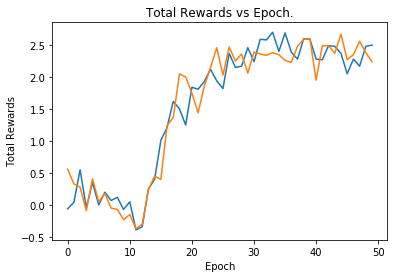

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(total_rewards[0])
plt.plot(total_rewards[1])
plt.ylabel('Total Rewards')
plt.xlabel('Epoch')
plt.title('Total Rewards vs Epoch.')
plt.show()

### Plot Actor Loss vs Epoch

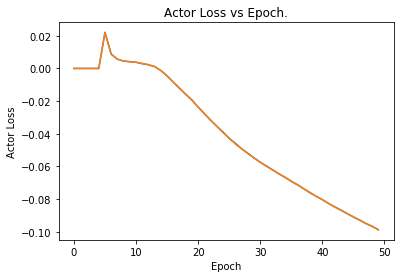

In [49]:
plt.plot(actor_losses[0])
plt.plot(actor_losses[1])
plt.ylabel('Actor Loss')
plt.xlabel('Epoch')
plt.title('Actor Loss vs Epoch.')
plt.show()

### Plot Critic Loss vs Epoch

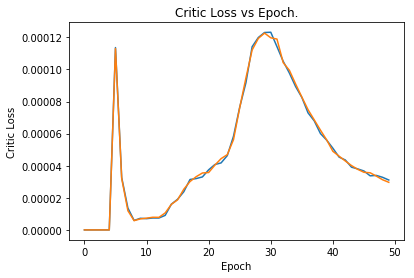

In [50]:
plt.plot(critic_losses[0])
plt.plot(critic_losses[1])
plt.ylabel('Critic Loss')
plt.xlabel('Epoch')
plt.title('Critic Loss vs Epoch.')
plt.show()

### Test the Agents by playing a series of games

Play 100 episodes (games) and track the score of the winning agent from each game.  Validate that the average score is over 0.5

The local networks seem to perform a little better than the targets.

The environment limits the game length to 1000 steps.  The agents must be achieving the maximum score possible at 2.6 - 2.7.

In [53]:
epsilon = 0.0
total_game_count = 100
best_agent_score_per_episode = []

player_0_model = actor_model_locals[0]
player_1_model = actor_model_locals[1]

#player_0_model = actor_model_targets[0]
#player_1_model = actor_model_targets[1]

for game_count in range(total_game_count):
    total_rewards_agent_0 = 0.0
    total_rewards_agent_1 = 0.0

    current_state = reset_game(env, brain_name)
    replay = []
    
    for i in range(2000):
        current_state = env_step(env, brain_name, current_state, replay, player_0_model, player_1_model, epsilon, logging=False)
        total_rewards_agent_0 += replay[-1].rewards[0]
        total_rewards_agent_1 += replay[-1].rewards[1]
        
        if np.any(replay[-1].dones):
            break
            
    best_agent_score_per_episode.append(max(total_rewards_agent_0, total_rewards_agent_1))
        
    print("game {}, total_rewards_agent_0: {:.3f}, total_rewards_agent_1: {:.3f}, game steps: {}".format(game_count+1, total_rewards_agent_0, total_rewards_agent_1, len(replay)))
    
print("Average max reward over {} games: {:.3f}".format(total_game_count, np.average(best_agent_score_per_episode)))


game 1, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2.600, game steps: 1001
game 2, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.700, game steps: 1001
game 3, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.600, game steps: 1001
game 4, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2.600, game steps: 1001
game 5, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.700, game steps: 1001
game 6, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.600, game steps: 1001
game 7, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2.600, game steps: 1001
game 8, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.700, game steps: 1001
game 9, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2.600, game steps: 1001
game 10, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.600, game steps: 1001
game 11, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.700, game steps: 1001
game 12, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2

game 97, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.600, game steps: 1001
game 98, total_rewards_agent_0: 2.700, total_rewards_agent_1: 2.600, game steps: 1001
game 99, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.700, game steps: 1001
game 100, total_rewards_agent_0: 2.600, total_rewards_agent_1: 2.600, game steps: 1001
Average max reward over 100 games: 2.587
